# Lab 2: Camera Calibration Using a Planar Pattern

Welcome to your second lab! In this assignment, you’ll explore how to **calibrate a camera** using a planar pattern. This is a fundamental step in many computer vision applications, including Augmented Reality. Get ready to recover internal camera parameters and visualize your camera in 3D!

## About the Lab
### What You'll Learn
1. **Estimating Internal Camera Parameters:**  
   You'll learn how to compute the internal parameters of a camera from images of a planar pattern using the **Image of the Absolute Conic (IAC)**.

2. **Finding Camera Pose:**  
   From homographies, you’ll extract the **pose of the camera** (its rotation and translation) relative to the calibration pattern.

3. **Augmented Reality Basics:**  
   By estimating camera pose, you’ll be able to **overlay virtual 3D objects** onto the images – just like in AR apps!

### Assumptions
We will assume you are already familiar with the following concepts:

- The definition of a **homography**, how to match **ORB/SIFT/SURF keypoints** between images, and how to robustly compute a homography from point correspondences.

- The **camera projection matrix**, including the difference between internal and external camera parameters, and their combined matrix form: $P = K ( R \mid t)$

- The concept of the **Image of the Absolute Conic (IAC)**, and its relationship to the internal calibration matrix \( K \), given by: $\omega = (K K ^T)^{-1} = K^{-T} K^{-1}$

### Deliverables:
1. 💻 **Complete the Code:**  
   You’ll implement the necessary steps to calibrate the camera and visualize its pose. Submit your completed and fully-executed Jupyter Notebook (.ipynb).

2. 🎥 **Explain Your Work:**  
   Record a short video explaining your approach and results. Follow the same format as in Lab 1 — walk us through your code and outcomes.

Let’s go calibrate some cameras! 🔧📷✨


<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color:rgba(255, 255, 255, 0);">
  <strong>🎥 Introduction</strong>:
  <ul>
    <li>Provide an overall explanation of the lab. Describe the goals of the lab clearly.</li>
    <li>State the problem you were trying to solve or explore in this lab.</li>
  </ul>
</div>


### 0 Import libraries
If the setup was correct, you should be able to import the libraries below.

In [1]:
import math

import cv2
import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from utils import * # Ransac_DLT_homography, plot_camera, plot_image_origin
from scipy.linalg import cholesky

If you were able to **import the libraries without errors**, you can **remove cells of the options that you are NOT using**. It will be easier to run the entire notebook.

## 1. Calibration with a planar pattern



### The Planar Pattern

For calibration, we need a known planar pattern. This is typically a checkerboard (left), which allows easy detection of corners. However, for simplicity, we will instead display a **texture-rich image** (center) on a flat screen (right). This image will serve as our calibration target.

To detect and match points between the calibration image on the screen and the reference image stored on your computer, you’ll use the **SIFT descriptor**. These correspondences will then allow you to compute the homographies needed for calibration.

<div style="display: flex; gap: 20px;">
  <div style="flex: 1; text-align: center;">
    <img src="./Data/Checkerboard.png" alt="Checkerboard" width="70%"><br>
    <strong>Checkerboard Pattern</strong>
  </div>
  <div style="flex: 1; text-align: center;">
    <img src="./Data/template.jpg" alt="Template" width="80%"><br>
    <strong>Calibration Template</strong>
  </div>
  <div style="flex: 1; text-align: center;">
    <img src="./Data/image1.jpg" alt="Template" width="80%"><br>
    <strong>Calibration template displayed on a flat screen</strong>
  </div>
</div>

### 1.0 Visualise template and images from different positions
Let's first visualise the template image and the images containing a planar surface with the template from different positions.

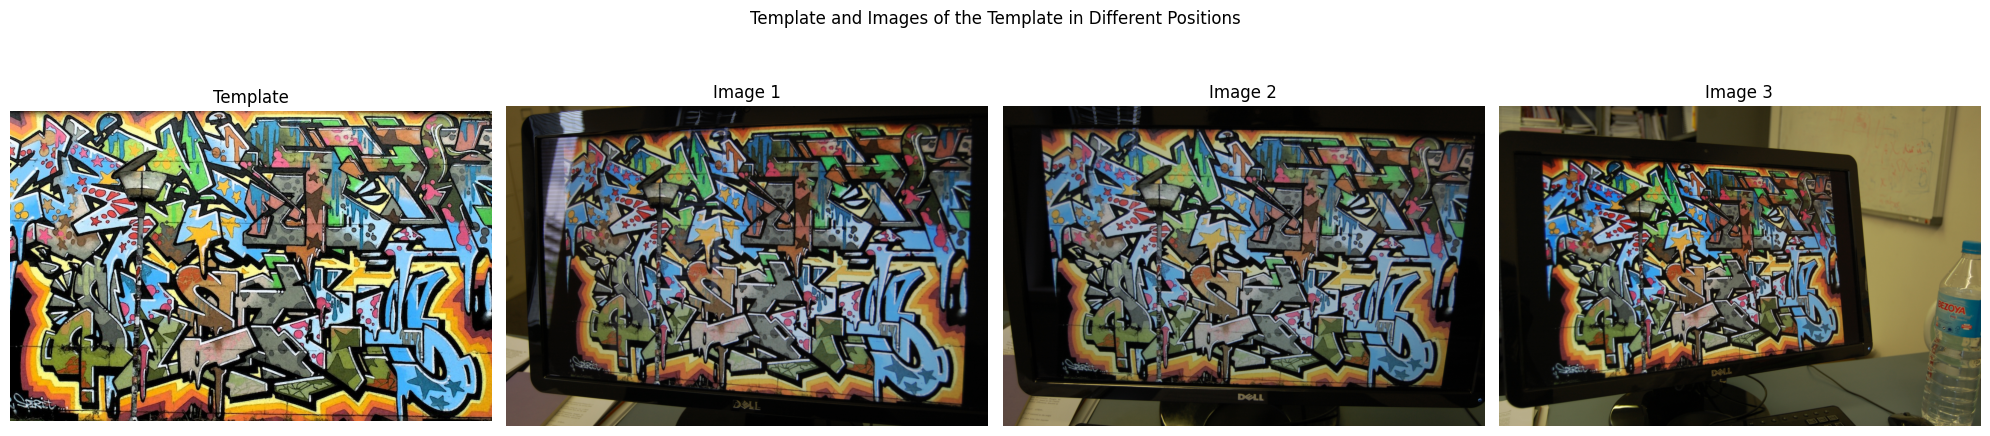

In [2]:
# Load the template image and convert it to RGB color space
template_path = "Data/template.jpg"
template_color = cv2.imread(template_path, cv2.IMREAD_COLOR)
template_color_rgb = cv2.cvtColor(template_color, cv2.COLOR_BGR2RGB)

# Number of images
N = 3

# Load the images and convert them to RGB color space
image_paths = [f"Data/image{i}.jpg" for i in range(1, N + 1)]
images_color_rgb = [cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB) for path in image_paths]

# Plot the template and images
fig, axes = plt.subplots(1, N + 1, figsize=(5 * (N + 1), 5))
fig.suptitle("Template and Images of the Template in Different Positions")

# Plot the template
axes[0].imshow(template_color_rgb)
axes[0].set_title("Template")
axes[0].axis("off")

# Plot the images
for i, img in enumerate(images_color_rgb, start=1):
    axes[i].imshow(img)
    axes[i].set_title(f"Image {i}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

### 2.1 Compute Homographies Between Template and Images
As in the previous session, we will compute homographies between the template and the images using SIFT matching and RANSAC.

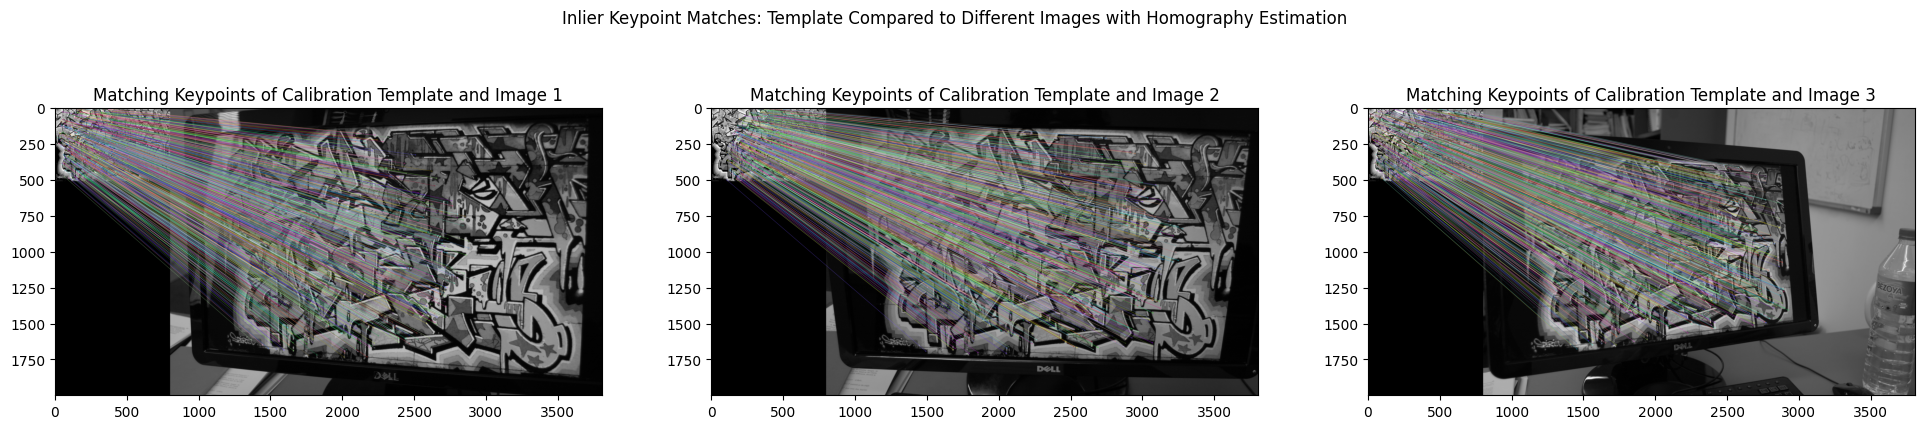

In [3]:
# Load template and images in grayscale
template_path = "Data/template.jpg"
template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
images = [cv2.imread(f"Data/image{i}.jpg", cv2.IMREAD_GRAYSCALE) for i in range(1, N + 1)]

# Find keypoints and descriptors of template and images with SIFT
sift = cv2.SIFT_create(4000)
keypoints_template, descriptors_template = sift.detectAndCompute(template, None)
keypoints_images, descriptors_images = [], []
for img in images:
    keypoints, descriptors = sift.detectAndCompute(img, None)
    keypoints_images.append(keypoints)
    descriptors_images.append(descriptors)

# Keypoint matching and homography estimation
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
homographies = []
plt.figure(figsize=(8 * N, 5))
plt.suptitle("Inlier Keypoint Matches: Template Compared to Different Images with Homography Estimation")
for i, img in enumerate(images):
    matches = bf.match(descriptors_template, descriptors_images[i])

    # Prepare corresponding point sets for homography estimation
    points_template = np.array(
        [[keypoints_template[m.queryIdx].pt[0], keypoints_template[m.queryIdx].pt[1], 1] for m in matches]
    )
    points_image = np.array(
        [[keypoints_images[i][m.trainIdx].pt[0], keypoints_images[i][m.trainIdx].pt[1], 1] for m in matches]
    )

    # Fit homography and find inliers with RANSAC
    H, indices_inlier_matches = Ransac_DLT_homography(points_template.T, points_image.T, 3, 1000)
    homographies.append(H)

    # Show inlier matches
    inlier_matches = [matches[idx] for idx in indices_inlier_matches]
    img_matched = cv2.drawMatches(
        template,
        keypoints_template,
        img,
        keypoints_images[i],
        inlier_matches,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )
    plt.subplot(1, N, i + 1)
    plt.title(f"Matching Keypoints of Calibration Template and Image {i + 1}")
    plt.imshow(img_matched)
plt.show()

### 2.2 Compute the Image of the Absolute Conic

Given the homographies we are now going to compute the Image of the Absolute conic (IAC).  Read carefully the theory in the provided file 'calibration.pdf'.

**Q1.** Complete the code below to compute the IAC from the homographies. Note that $\Omega$ is `omega_vec` and $\omega$ is `omega_mat`.

In [4]:
# Compute the Image of the Absolute Conic
def get_v_ij_T(H, i, j):
    """
    Compute the elements of the v_ij vector for a given homography H and indices i, j.

    Parameters:
    - H (numpy.ndarray): Homography matrix.
    - i (int): Index of the first column of H.
    - j (int): Index of the second column of H.

    Returns:
    - numpy.ndarray: Array containing the elements of the v_ij vector computed from H, i, and j.
    """
    # Initialize array 'a' to store elements of V matrix
    a = np.zeros(6)
    a[0] = H[0, i] * H[0, j]
    a[1] = H[0, i] * H[1, j] + H[1, i] * H[0, j]
    a[2] = H[0, i] * H[2, j] + H[2, i] * H[0, j]
    a[3] = H[1, i] * H[1, j]
    # TODO: Complete
    # NOTE: extracted from EQ.12 from calibration.pdf
    a[4] = H[1, i] * H[2, j] + H[2, i] * H[1, j]
    a[5] = H[2, i] * H[2, j]

    return a


# Initialize matrix V with zeros
V = np.zeros((2 * N, 6))

# Loop over each homography and compute corresponding elements of V matrix
for h_idx in range(N):
    # Select homography matrix corresponding to the current iteration
    H = homographies[h_idx]

    # Compute elements of V matrix for the current homography and store them in V
    V[2 * h_idx, :] = get_v_ij_T(H, i=0, j=1)
    V[2 * h_idx + 1, :] = get_v_ij_T(H, i=0, j=0) - get_v_ij_T(H, i=1, j=1)

display(V)

# TODO: Find omega_vec which has the form [ω_11, ω_12, ω_13, ω_22, ω_23, ω_33]
# NOTE: Find solution to V @ omega_vec = 0
_, _, Vh = np.linalg.svd(V)
omega_vec = Vh[-1, :]

# TODO: Find omega_mat, the IAC (Image of the Absolute Conic)
# NOTE: fancy numpy way, similar to https://youtu.be/UbmOKqi1mgo?si=KCs1-G-3ziA0MpKU
# set upper triangular matrix 
omega_mat = np.zeros((3, 3))
idx, col = np.triu_indices(3, k=0)
omega_mat[idx, col] = omega_vec

# sum by transpose, removing diagonal
omega_mat = omega_mat + np.triu(omega_mat, k=1).T

print("omega_vec:", omega_vec)
print("\nomega_mat:", omega_mat)

array([[ 3.42393276e-01,  8.45403301e+00,  1.88007706e-04,
        -6.52297991e-01, -8.47945425e-04, -2.17079111e-08],
       [ 7.00238822e+00, -1.90714674e+00, -1.39707121e-03,
        -1.02043388e+01, -4.29562023e-04,  6.03900424e-08],
       [ 1.20073163e+00,  1.06093156e+01,  8.89999919e-04,
         1.70636591e-01, -5.09780979e-05, -5.54539638e-09],
       [ 9.81581523e+00, -2.23222150e+00, -3.39463288e-04,
        -1.12565606e+01, -1.91023823e-03, -8.04747378e-08],
       [ 2.76505719e-01,  6.28291486e+00, -8.71126501e-05,
         5.69444824e-01,  7.88221879e-04, -1.56395961e-08],
       [ 7.08676235e+00,  8.04147878e-01,  1.82281240e-03,
        -5.45856272e+00,  3.80898835e-04,  1.13701414e-07]])

omega_vec: [ 8.23533382e-08 -2.26880636e-10 -1.19523562e-04  8.22241721e-08
 -8.19146319e-05  9.99999990e-01]

omega_mat: [[ 8.23533382e-08 -2.26880636e-10 -1.19523562e-04]
 [-2.26880636e-10  8.22241721e-08 -8.19146319e-05]
 [-1.19523562e-04 -8.19146319e-05  9.99999990e-01]]


<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color: rgba(255, 255, 255, 0);">
  <ul style="margin: 0; padding-left: 20px;">
    <strong>🎥 Video Question 2:</strong><br>
    <li>How many images are required to compute the IAC? Why?<br>
    <li>What would you do if you had fewer images?
  </ul>
</div>

### 2.3 Compute the camera calibration matrix from the IAC

The IAC relates to the camera calibration matrix, $K$ as $\omega = K^{-T} K^{-1}$. Knowing $\omega$ (`omega_mat`) we can get $K$ using the Cholesky factorization.

**Q3.** Write the code to compute the camera calibration matrix from the IAC $\omega$.

In [5]:
# TODO: Find K with Cholesky
# NOTE: from theory class, omega_mat = inv(KK') --> KK' = inv(omega_mat)
# NOTE: WHY DOES THIS NOT WORK !!!
# K = cholesky(np.linalg.inv(omega_mat), lower=True).T
# K = cholesky(np.linalg.inv(omega_mat))

K = np.linalg.inv(cholesky(omega_mat))
K /= K[-1, -1]

print("Estimated camera calibration matrix K:", K, sep="\n")

Estimated camera calibration matrix K:
[[3.00623708e+03 8.28861468e+00 1.45410619e+03]
 [0.00000000e+00 3.00860884e+03 1.00024772e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color: rgba(255, 255, 255, 0);">
  <strong>🎥 Video Question (Q4):</strong>
  <ul>
    <li>What result do you get?</li>
    <li>Can you interpret the values of <span style="font-family: 'Times New Roman', serif;">K</span> in geometric terms?</li>
    <li>Which ones are related to the image size? How are they related? Do they make sense in your results?</li>
  </ul>
</div>

**Q5.** Compute the field of view angle of the camera.

In [6]:
'''
K = [[a_x   s   p_X_hat],
     [ 0   a_Y  p_Y_hat],
     [ 0    0      1   ]]

tan(fov / 2) = p_X / a_X --> arctan(p_X / a_X) = fov / 2 --> fov = arctan(p_X / a_X) * 2

where a_X, a_Y are the true dimensions of the image,
and a_X_hat, a_Y_hat are the estimated dimensions of the image
'''

# NOTE: at first got wrong the trig function. Used cosine, is tangent
# NOTE: at first got width and height from the image estimated values, not very accurate
fov_x_deg = np.rad2deg(np.arctan(images[0].shape[0] / K[0, 0]) * 2)
fov_y_deg = np.rad2deg(np.arctan(images[0].shape[1] / K[1, 1]) * 2)
print(f"Estimated horizontal FOV (x): {fov_x_deg:.2f} degrees")
print(f"Estimated vertical FOV (y): {fov_y_deg:.2f} degrees")

Estimated horizontal FOV (x): 67.27 degrees
Estimated vertical FOV (y): 89.99 degrees


### 2.4 Compute camera position and orientation

Given the computed calibration $K$ and the homografies $H$, we can compute the 3D position and orientation of the camera with respect to the planar pattern.

**Q6.** Complete the code to compute the rotation and translation of each camera.


In [7]:
# Compute camera position and orientation
rotations = []
translations = []
projection_matrices = []

for img_idx in range(N):
    H = homographies[img_idx]

    # TODO: Compute r1, r2, t
    r1, r2, t = np.transpose(np.linalg.inv(K) @ H) # assignment is done wrt rows, so transpose

    # Solve scale ambiguity
    s = math.sqrt(np.linalg.norm(r1) * np.linalg.norm(r2)) * np.sign(t[2])
    r1 = r1 / s
    r2 = r2 / s
    t = t / s
    translations.append(t)

    # TODO: Compute r3
    r3 = np.cross(r1, r2)

    # Assemble rotation matrix
    R = np.column_stack((r1, r2, r3))

    # Orthonormalize R with SVD to make it a valid rotation matrix
    # i.e., approximate R to a rotation matrix with unitary singular values
    U, _, Vt = np.linalg.svd(R)
    R = U @ np.identity(3) @ Vt
    rotations.append(R)

    # TODO: Compute projection matrix P = K [R | t]
    extrinsics = np.column_stack((R, t.reshape(-1, 1)))
    P = K @ extrinsics
    projection_matrices.append(P)

<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color: rgba(255, 255, 255, 0);">
  <strong>🎥 Video Question (Q7):</strong>
  <ul>
    <li>In which units is the translation vector <b>t</b> expressed?</li>
  </ul>
</div>

The following code visualizes, in 3D, the different cameras corresponding to each image, along with the rectangular frame of the planar pattern. Each camera is represented as a pyramid, where the apex indicates the estimated camera position, and the base reflects its orientation with respect to the planar scene.

In [8]:
img_h, img_w = images[0].shape

fig = go.Figure()
for img_idx in range(N):
    plot_camera(projection_matrices[img_idx], img_w, img_h, fig, f"Camera {img_idx+1}")

plot_image_origin(img_w/2, img_h/2, fig, "Image")

fig.show()

**Q8.** Complete the code below to plot a moving planar target in front of a static camera.


In [9]:
def plot_image_Rt(R, t, w, h, fig, legend):
    """
    Plot the camera pose and image plane in 3D space.

    Parameters:
        R (numpy.ndarray): Rotation matrix.
        t (numpy.ndarray): Translation vector.
        w (float): Width of the image plane.
        h (float): Height of the image plane.
        fig: Plotly figure object.
        legend (str): Legend label for the plot.

    Returns:
        None
    """
    # TODO: Define the vertices of the image plane
    p1 = np.array([0, 0, 1])
    p2 = np.array([w, 0, 1])
    p3 = np.array([w, h, 1])
    p4 = np.array([0, h, 1])

    # TODO: Project the vertices to the camera coordinates
    tmp = np.column_stack((R[:, 0:2], t.reshape(-1, 1)))
    p1 = tmp @ p1
    p2 = tmp @ p2
    p3 = tmp @ p3
    p4 = tmp @ p4

    # Extract coordinates for plotting
    x = np.array([p1[0], p2[0], p3[0], p4[0], p1[0]])
    y = np.array([p1[1], p2[1], p3[1], p4[1], p1[1]])
    z = np.array([p1[2], p2[2], p3[2], p4[2], p1[2]])

    fig.add_trace(go.Scatter3d(x=x, y=z, z=-y, mode="lines", name=legend))

    return


fig = go.Figure()
A = np.column_stack((np.identity(3), np.zeros(3)))
plot_camera(K @ A, img_w, img_h, fig, "Camera")
for i in range(N):
    plot_image_Rt(rotations[i], translations[i], img_w / 2, img_h / 2, fig, f"Image {i+1}")

fig.show()

<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color: rgba(255, 255, 255, 0);">
  <strong>🎥 Video Question (Q9):</strong>
  <ul>
    <li>When taking the images, we moved the camera and the planar pattern was static. The previous 3D plot shows a moving pattern in front of a static camera.  What is the relation between the two situations?</li>
    <li> Do the results make sense to you?</li>
  </ul>
</div>

### 2.5 Augmented reality

We now have the projection matrices, $P$, of each image with respect to the planar target's reference frame. We can use these projection matrices for projecting 3D points onto the images. Given a 3D point, we can project it using the projection matrix and plot the projection over the image.

**Q10.** Complete the code below to plot a cube in front of the calibration pattern on each image. The result should look as if a cube was attached to the pattern as the pattern moves from image to image.

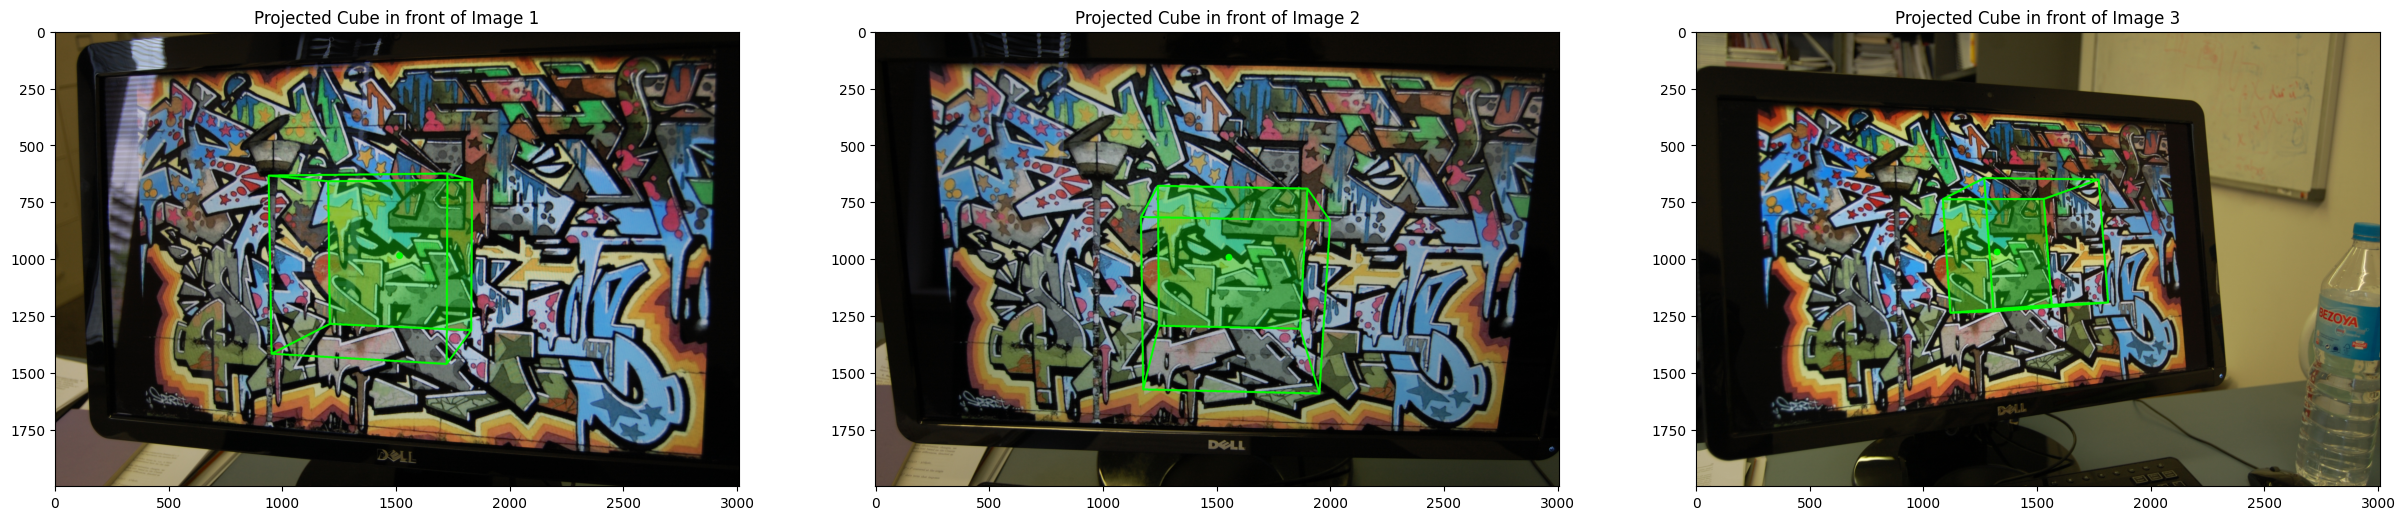

In [10]:
# Define the vertices of the cube
cube_vertices = np.array(
    [
        [0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],  # Front vertices
        [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1],  # Back vertices
    ],
    dtype=np.float64,
).T

# Translate the vertices to the center of the back face
cube_backface_centre = np.array([[0.5, 0.5, 1]]).T
cube_vertices -= cube_backface_centre

# Scale the vertices based on the width of the template image
template_height, template_width = template.shape
scaling_factor = template_width / 4
cube_vertices *= scaling_factor

# Translate the vertices to the center of the template image
image_centre = np.array([[template_width / 2, template_height / 2, 0]]).T
cube_vertices += image_centre

# Convert vertices to homogeneous coordinates
cube_vertices = np.vstack((cube_vertices, np.ones((1, cube_vertices.shape[1]))))

# Define edges of the cube
cube_edges_idxs = [
    [0, 1], [1, 2], [2, 3], [3, 0],  # Front face edges
    [4, 5], [5, 6], [6, 7], [7, 4],  # Back face edges
    [0, 4], [1, 5], [2, 6], [3, 7],  # Connecting edges between Front and Back faces
]

# Define line color for drawing edges
LINE_COLOR = (0, 255, 0)

# Create a plot for each image
plt.figure(figsize=(10 * N, 8))
for i in range(N):
    # TODO: Project vertices onto the image plane using the projection matrix
    # Remember to normalize to homogeneous coordinates and convert it to pixels (integers, not floats)
    xp = projection_matrices[i] @ cube_vertices

    xp /= xp[-1, :]

    xp = np.round(xp)
    xp = xp.astype(np.int32) # xp.astype(int) was not working !!!!!!! silly bug

    # Read the original image
    original_image = cv2.imread("Data/image{0}.jpg".format(i + 1), cv2.IMREAD_COLOR)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Fill the back face of the cube with 30% transparency
    image = original_image.copy()
    xp_backface = xp[:2, -4:].T
    image = cv2.fillPoly(image, pts=[xp_backface], color=LINE_COLOR)
    alpha = 0.3
    image = cv2.addWeighted(src1=image, alpha=alpha, src2=original_image, beta=1 - alpha, gamma=0)

    # Draw cube edges
    for vertex_a_idx, vertex_b_idx in cube_edges_idxs:
        image = cv2.line(image, (xp[:2, vertex_a_idx]), (xp[:2, vertex_b_idx]), LINE_COLOR, 8)

    # Draw a circle at the center of the back face
    backface_centre = np.mean(xp[:, (4, 6)], axis=1, dtype=np.int32)
    image = cv2.circle(image, backface_centre[:2], radius=5, color=LINE_COLOR, thickness=20)

    # Show the image with the projected cube
    plt.subplot(1, N, i + 1)
    plt.imshow(image)
    plt.title(f"Projected Cube in front of Image {i+1}")
plt.show()

**Q11.** Repeat all the process using your own images (you may use from 3 to 5 different views of a planar pattern). Comment the results and try to find an explanation in case it doesn't work.


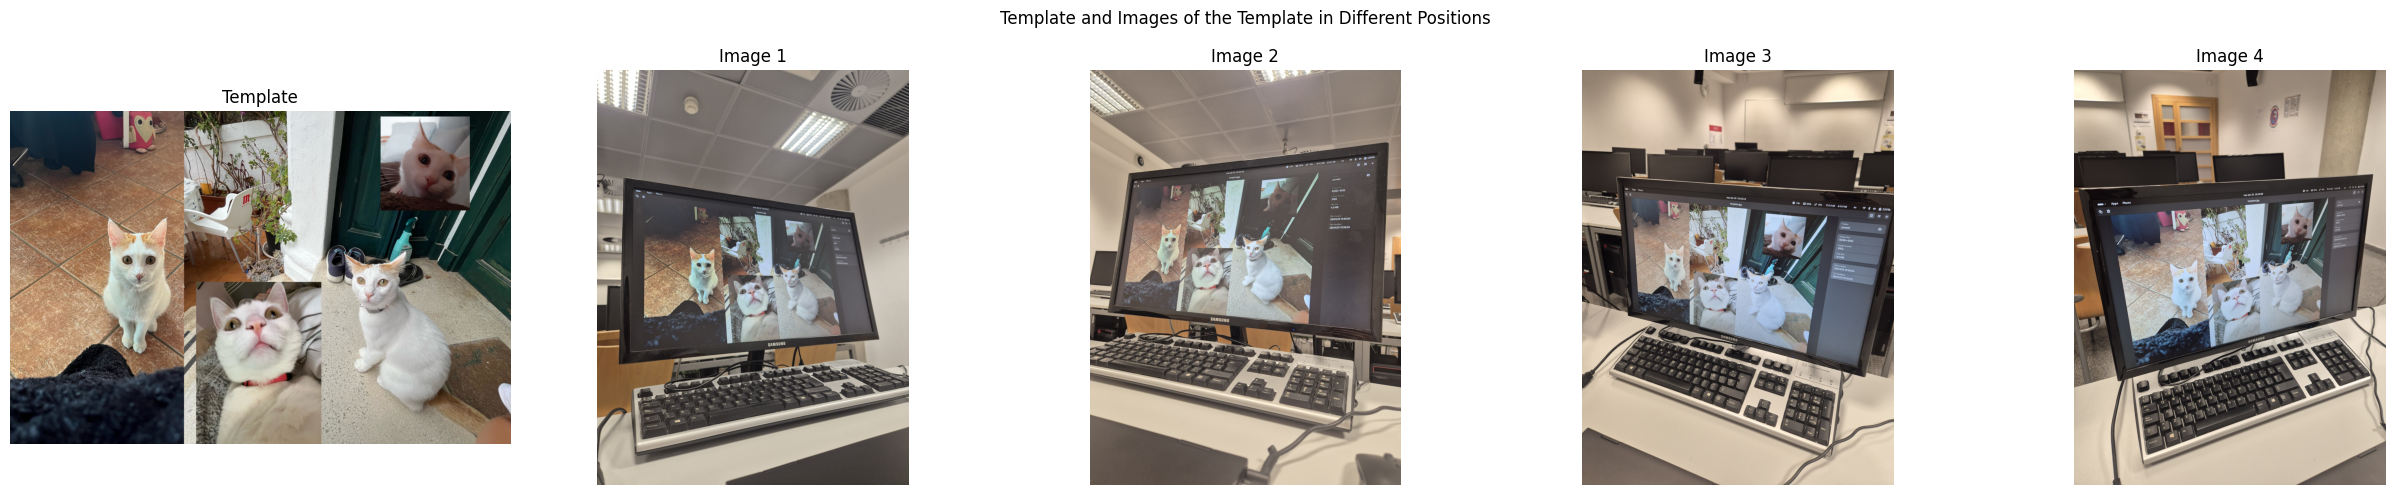

In [11]:
# Load the template image and convert it to RGB color space
template_path = "Data/punxoli/template.jpg"
template_color = cv2.imread(template_path, cv2.IMREAD_COLOR)
template_color_rgb = cv2.cvtColor(template_color, cv2.COLOR_BGR2RGB)

# Number of images
N = 4

# Load the images and convert them to RGB color space
image_paths = [f"Data/punxoli/image{i}.jpg" for i in range(1, N + 1)]
images_color_rgb = [cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB) for path in image_paths]

# Plot the template and images
fig, axes = plt.subplots(1, N + 1, figsize=(5 * (N + 1), 5))
fig.suptitle("Template and Images of the Template in Different Positions")

# Plot the template
axes[0].imshow(template_color_rgb)
axes[0].set_title("Template")
axes[0].axis("off")

# Plot the images
for i, img in enumerate(images_color_rgb, start=1):
    axes[i].imshow(img)
    axes[i].set_title(f"Image {i}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

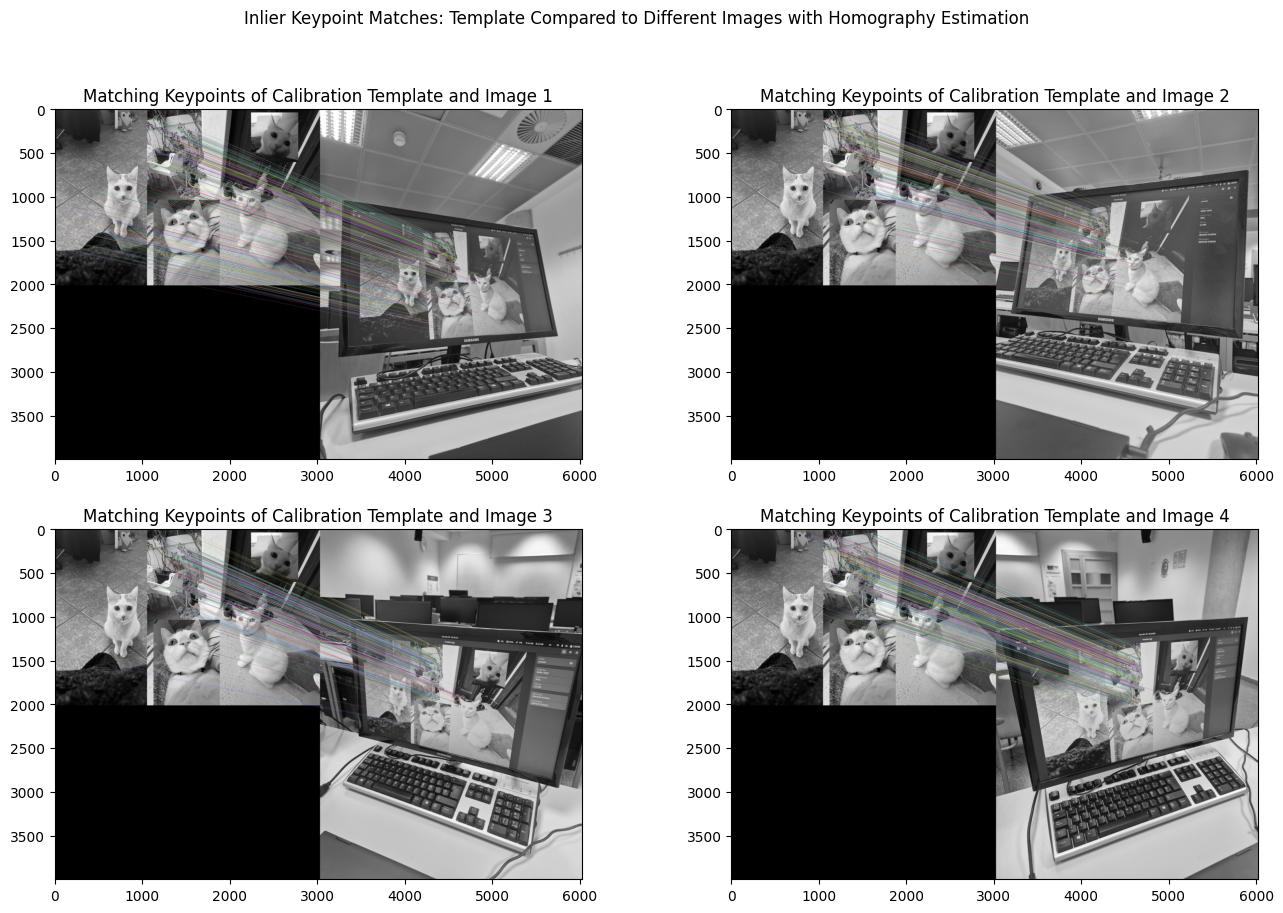

In [12]:
# Load template and images in grayscale
template_path = "Data/punxoli/template.jpg"
template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
images = [cv2.imread(f"Data/punxoli/image{i}.jpg", cv2.IMREAD_GRAYSCALE) for i in range(1, N + 1)]

# Find keypoints and descriptors of template and images with SIFT
sift = cv2.SIFT_create(4000)
keypoints_template, descriptors_template = sift.detectAndCompute(template, None)
keypoints_images, descriptors_images = [], []
for img in images:
    keypoints, descriptors = sift.detectAndCompute(img, None)
    keypoints_images.append(keypoints)
    descriptors_images.append(descriptors)

# Keypoint matching and homography estimation
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
homographies = []
plt.figure(figsize=(8 * N / 2, 5 * 2))
plt.suptitle("Inlier Keypoint Matches: Template Compared to Different Images with Homography Estimation")
for i, img in enumerate(images):
    matches = bf.match(descriptors_template, descriptors_images[i])

    # Prepare corresponding point sets for homography estimation
    points_template = np.array(
        [[keypoints_template[m.queryIdx].pt[0], keypoints_template[m.queryIdx].pt[1], 1] for m in matches]
    )
    points_image = np.array(
        [[keypoints_images[i][m.trainIdx].pt[0], keypoints_images[i][m.trainIdx].pt[1], 1] for m in matches]
    )

    # Fit homography and find inliers with RANSAC
    H, indices_inlier_matches = Ransac_DLT_homography(points_template.T, points_image.T, 3, 1000)
    homographies.append(H)

    # Show inlier matches
    inlier_matches = [matches[idx] for idx in indices_inlier_matches]
    img_matched = cv2.drawMatches(
        template,
        keypoints_template,
        img,
        keypoints_images[i],
        inlier_matches,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )
    plt.subplot(2, int(N / 2), i + 1)
    plt.title(f"Matching Keypoints of Calibration Template and Image {i + 1}")
    plt.imshow(img_matched)
plt.show()

In [13]:
_, _, Vh = np.linalg.svd(V)
omega_vec = Vh[-1, :]

omega_mat = np.zeros((3, 3))
idx, col = np.triu_indices(3, k=0)
omega_mat[idx, col] = omega_vec

omega_mat = omega_mat + np.triu(omega_mat, k=1).T

K = np.linalg.inv(cholesky(omega_mat))
K /= K[-1, -1]

fov_x_deg = np.rad2deg(np.arctan(images[0].shape[0] / K[0, 0]) * 2)
fov_y_deg = np.rad2deg(np.arctan(images[0].shape[1] / K[1, 1]) * 2)

In [14]:
rotations = []
translations = []
projection_matrices = []

for img_idx in range(N):
    H = homographies[img_idx]

    # TODO: Compute r1, r2, t
    r1, r2, t = np.transpose(np.linalg.inv(K) @ H) # assignment is done wrt rows, so transpose

    # Solve scale ambiguity
    s = math.sqrt(np.linalg.norm(r1) * np.linalg.norm(r2)) * np.sign(t[2])
    r1 = r1 / s
    r2 = r2 / s
    t = t / s
    translations.append(t)

    # TODO: Compute r3
    r3 = np.cross(r1, r2)

    # Assemble rotation matrix
    R = np.column_stack((r1, r2, r3))

    # Orthonormalize R with SVD to make it a valid rotation matrix
    # i.e., approximate R to a rotation matrix with unitary singular values
    U, _, Vt = np.linalg.svd(R)
    R = U @ np.identity(3) @ Vt
    rotations.append(R)

    # TODO: Compute projection matrix P = K [R | t]
    extrinsics = np.column_stack((R, t.reshape(-1, 1)))
    P = K @ extrinsics
    projection_matrices.append(P)

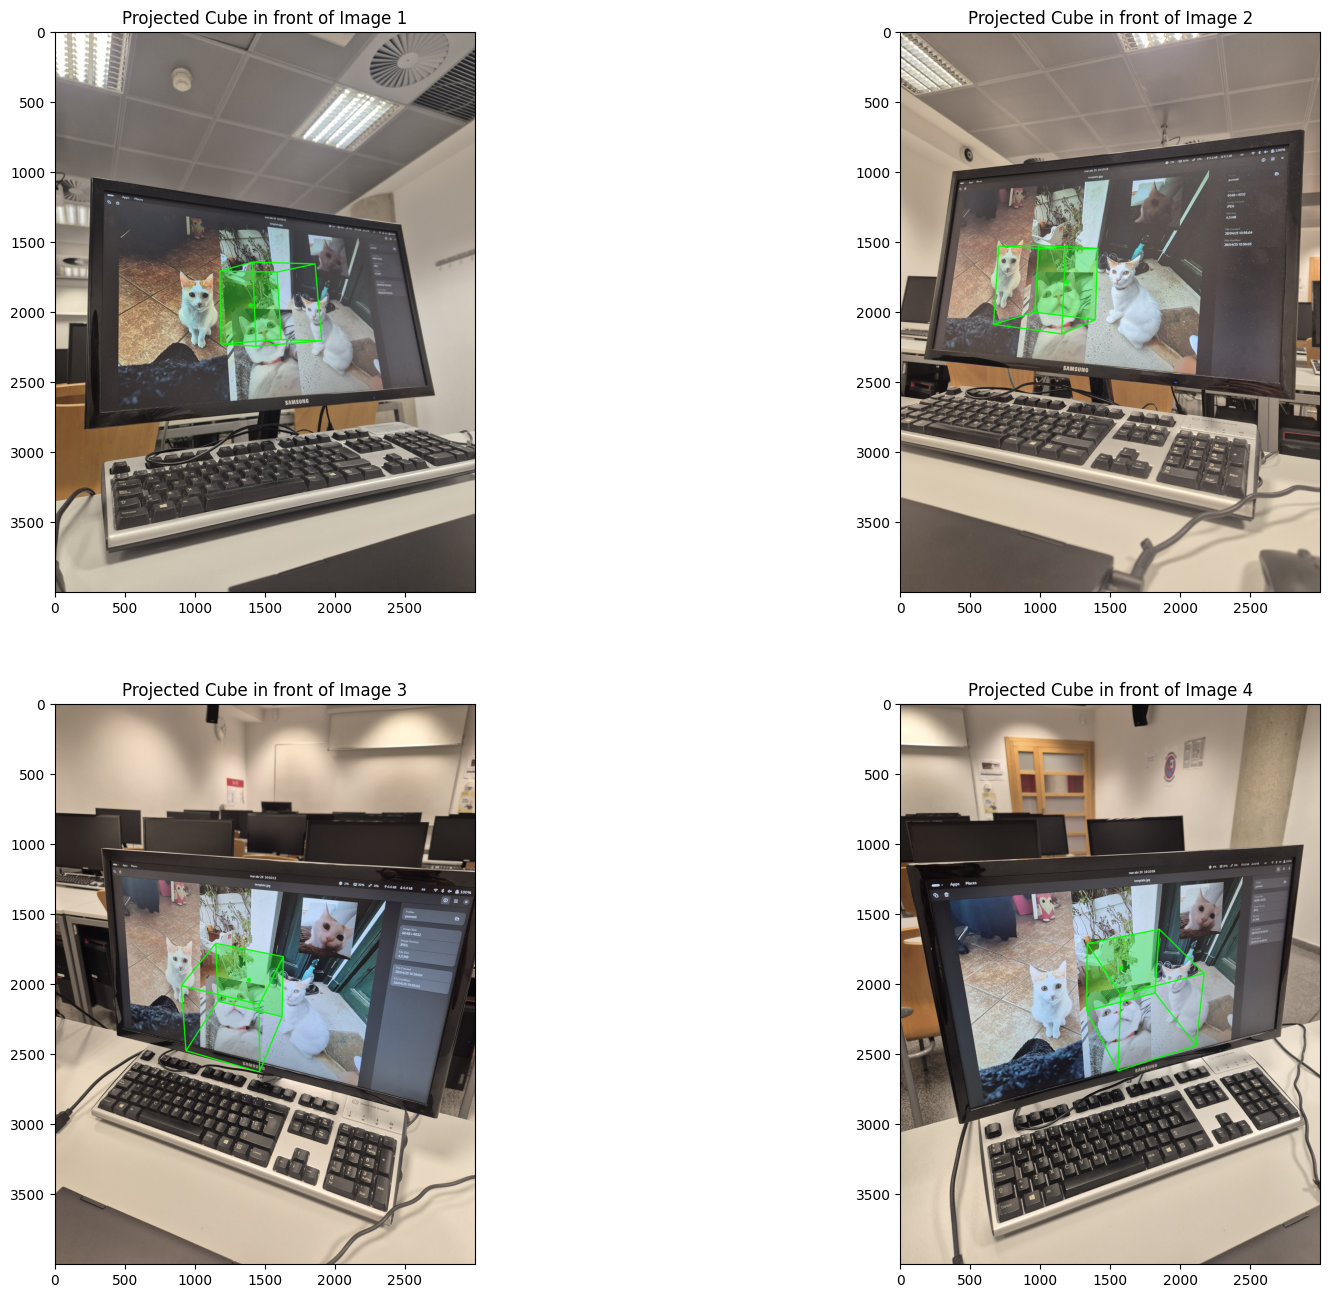

In [15]:
# Define the vertices of the cube
cube_vertices = np.array(
    [
        [0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],  # Front vertices
        [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1],  # Back vertices
    ],
    dtype=np.float64,
).T

# Translate the vertices to the center of the back face
cube_backface_centre = np.array([[0.5, 0.5, 1]]).T
cube_vertices -= cube_backface_centre

# Scale the vertices based on the width of the template image
template_height, template_width = template.shape
scaling_factor = template_width / 4
cube_vertices *= scaling_factor

# Translate the vertices to the center of the template image
image_centre = np.array([[template_width / 2, template_height / 2, 0]]).T
cube_vertices += image_centre

# Convert vertices to homogeneous coordinates
cube_vertices = np.vstack((cube_vertices, np.ones((1, cube_vertices.shape[1]))))

# Define edges of the cube
cube_edges_idxs = [
    [0, 1], [1, 2], [2, 3], [3, 0],  # Front face edges
    [4, 5], [5, 6], [6, 7], [7, 4],  # Back face edges
    [0, 4], [1, 5], [2, 6], [3, 7],  # Connecting edges between Front and Back faces
]

# Define line color for drawing edges
LINE_COLOR = (0, 255, 0)
# Create a plot for each image
plt.figure(figsize=(10 * N / 2, 8 * 2))
for i in range(N):
    # TODO: Project vertices onto the image plane using the projection matrix
    # Remember to normalize to homogeneous coordinates and convert it to pixels (integers, not floats)
    xp = projection_matrices[i] @ cube_vertices

    xp /= xp[-1, :]

    xp = np.round(xp)
    xp = xp.astype(np.int32) # xp.astype(int) was not working !!!!!!! silly bug

    # Read the original image
    original_image = cv2.imread("Data/punxoli/image{0}.jpg".format(i + 1), cv2.IMREAD_COLOR)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Fill the back face of the cube with 30% transparency
    image = original_image.copy()
    xp_backface = xp[:2, -4:].T
    image = cv2.fillPoly(image, pts=[xp_backface], color=LINE_COLOR)
    alpha = 0.3
    image = cv2.addWeighted(src1=image, alpha=alpha, src2=original_image, beta=1 - alpha, gamma=0)

    # Draw cube edges
    for vertex_a_idx, vertex_b_idx in cube_edges_idxs:
        image = cv2.line(image, (xp[:2, vertex_a_idx]), (xp[:2, vertex_b_idx]), LINE_COLOR, 8)

    # Draw a circle at the center of the back face
    backface_centre = np.mean(xp[:, (4, 6)], axis=1, dtype=np.int32)
    image = cv2.circle(image, backface_centre[:2], radius=5, color=LINE_COLOR, thickness=20)

    # Show the image with the projected cube
    plt.subplot(2, int(N / 2), i + 1)
    plt.imshow(image)
    plt.title(f"Projected Cube in front of Image {i+1}")
plt.show()


### 2.6 Reducing the number of images

In case we have some knowledge about the camera parameters like the principal point, the aspect ratio or zero skew factor the number of images needed for calibration can be reduced.

**Q12. (Optional)** Add a linear constraint to enforce skew 0.  See Zhang's paper (zhang98.pdf) [1]. What is the minimum number of views you need to calibrate the camera in this case?

[1] Zhengyou Zhang. A flexible new technique for camera calibration, IEEE Transactions on pattern analysis and machine intelligence, 22(11), 1330-1334, 2000.


In [16]:
# TODO: Optional answer
# NOTE: If n = 2, we can impose the skewless constraint γ = 0, i.e., [0, 1, 0, 0, 0, 0]b = 0,
# which is added as an additional equation to (9)

N = 2

# Initialize matrix V with zeros
V = np.zeros((2 * N, 6))

# Loop over each homography and compute corresponding elements of V matrix
for h_idx in range(N):
    # Select homography matrix corresponding to the current iteration
    H = homographies[h_idx]

    # Compute elements of V matrix for the current homography and store them in V
    V[2 * h_idx, :] = get_v_ij_T(H, i=0, j=1)
    V[2 * h_idx + 1, :] = get_v_ij_T(H, i=0, j=0) - get_v_ij_T(H, i=1, j=1)

V = np.column_stack((V.T, np.array([0, 1, 0, 0, 0, 0]))).T # NOTE: WE ADD THIS WRT 2.2

_, _, Vh = np.linalg.svd(V)
omega_vec = Vh[-1, :]

omega_mat = np.zeros((3, 3))
idx, col = np.triu_indices(3, k=0)
omega_mat[idx, col] = omega_vec
omega_mat = omega_mat + np.triu(omega_mat, k=1).T

display(omega_mat)

array([[ 8.35517971e-08,  1.54848211e-21, -1.26168039e-04],
       [ 1.54848211e-21,  7.91835185e-08, -1.72495986e-04],
       [-1.26168039e-04, -1.72495986e-04,  9.99999977e-01]])


**Q13. (Optional)** Can you calibrate from a single image? How? Adapt your code to be able to calibrate from just a single image. Compare the results with the ones obtained when using more images. 


In [17]:
# TODO: Optional answer
# NOTE: (If n = 1, we can only solve two camera intrinsic parameters,
# e.g., α and β, assuming u0 and v0 are known (e.g., at the image center) and γ = 0, and that is indeed what we did in ...)
# NOTE: both u0 and v0 are assumed to be 0 in our case, because the principal point is usually at the center of the image.

N = 1

# Initialize matrix V with zeros
V = np.zeros((2 * N, 6))

# Loop over each homography and compute corresponding elements of V matrix
for h_idx in range(N):
    # Select homography matrix corresponding to the current iteration
    H = homographies[h_idx]

    # Compute elements of V matrix for the current homography and store them in V
    V[2 * h_idx, :] = get_v_ij_T(H, i=0, j=1)
    V[2 * h_idx + 1, :] = get_v_ij_T(H, i=0, j=0) - get_v_ij_T(H, i=1, j=1)

V = np.column_stack((V.T, np.array([0, 1, 0, 0, 0, 0]))).T
V = np.column_stack((V.T, np.array([0, 0, 1, 0, 0, 0]))).T # NOTE: WE ADD THIS WRT 2.6.1
V = np.column_stack((V.T, np.array([0, 0, 0, 0, 1, 0]))).T # NOTE: WE ADD THIS WRT 2.6.1

_, _, Vh = np.linalg.svd(V)
omega_vec = Vh[-1, :]

omega_mat = np.zeros((3, 3))
idx, col = np.triu_indices(3, k=0)
omega_mat[idx, col] = omega_vec
omega_mat = omega_mat + np.triu(omega_mat, k=1).T

display(omega_mat)

array([[ 7.09868408e-09, -4.96308368e-24,  9.56377096e-24],
       [-4.96308368e-24,  5.65337823e-08,  8.56261181e-25],
       [ 9.56377096e-24,  8.56261181e-25,  1.00000000e+00]])

In [18]:
K = np.linalg.inv(cholesky(omega_mat))
K /= K[-1, -1]

**Q14. Optional:** Using the last result you can create a video where the projected virtual cube automatically adapts to the changing point of view when you move the camera.


In [19]:
# Load template and images in grayscale
template_path = "Data/punxoli/template.jpg"
template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)

# Find keypoints and descriptors of template and images with SIFT
sift = cv2.SIFT_create(4000)
keypoints_template, descriptors_template = sift.detectAndCompute(template, None)

# Keypoint matching and homography estimation
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

video = cv2.VideoCapture('Data/punxoli/video.mp4')

if video.isOpened():
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    res=(int(width), int(height))

    # WHY AM I HAVING SO MANY PROBLEMS WITH VIDEO CODECS
    # NOTE: FALLING BACK TO mp4v BECAUSE H264 AND avc1 do not work
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') #codec 
    out = cv2.VideoWriter('Data/punxoli/output.mp4', fourcc, 30.0, res)
    frame = None
    while True:
        try:
            is_success, frame = video.read()
        except cv2.error:
            continue
        if not is_success:
            break
        
        # process the images
        original_image = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

        keypoints, descriptors = sift.detectAndCompute(original_image, None)
        keypoints_images = keypoints
        descriptors_images = descriptors

        matches = bf.match(descriptors_template, descriptors_images)

        # Prepare corresponding point sets for homography estimation
        points_template = np.array(
            [[keypoints_template[m.queryIdx].pt[0], keypoints_template[m.queryIdx].pt[1], 1] for m in matches]
        )
        points_image = np.array(
            [[keypoints_images[m.trainIdx].pt[0], keypoints_images[m.trainIdx].pt[1], 1] for m in matches]
        )

        # Fit homography and find inliers with RANSAC
        H, indices_inlier_matches = Ransac_DLT_homography(points_template.T, points_image.T, 3, 1000)

        display(H)

        # Initialize matrix V with zeros
        V = np.zeros((2 * N, 6))

        # Compute elements of V matrix for the current homography and store them in V
        V[0, :] = get_v_ij_T(H, i=0, j=1)
        V[1, :] = get_v_ij_T(H, i=0, j=0) - get_v_ij_T(H, i=1, j=1)

        V = np.column_stack((V.T, np.array([0, 1, 0, 0, 0, 0]))).T
        V = np.column_stack((V.T, np.array([0, 0, 1, 0, 0, 0]))).T # NOTE: WE ADD THIS WRT 2.6.1
        V = np.column_stack((V.T, np.array([0, 0, 0, 0, 1, 0]))).T # NOTE: WE ADD THIS WRT 2.6.1

        display(V)

        _, _, Vh = np.linalg.svd(V)
        omega_vec = Vh[-1, :]
        omega_vec = omega_vec / omega_vec[-1]

        omega_mat = np.zeros((3, 3))
        idx, col = np.triu_indices(3, k=0)
        omega_mat[idx, col] = omega_vec
        omega_mat = omega_mat + np.triu(omega_mat, k=1).T

        display(omega_mat)

        K = np.linalg.inv(cholesky(omega_mat))
        K /= K[-1, -1]

        fov_x_deg = np.rad2deg(np.arctan(width / K[0, 0]) * 2)
        fov_y_deg = np.rad2deg(np.arctan(height / K[1, 1]) * 2)

        # TODO: Compute r1, r2, t
        r1, r2, t = np.transpose(np.linalg.inv(K) @ H) # assignment is done wrt rows, so transpose

        # Solve scale ambiguity
        s = math.sqrt(np.linalg.norm(r1) * np.linalg.norm(r2)) * np.sign(t[2])
        r1 = r1 / s
        r2 = r2 / s
        t = t / s

        # TODO: Compute r3
        r3 = np.cross(r1, r2)

        # Assemble rotation matrix
        R = np.column_stack((r1, r2, r3))

        # Orthonormalize R with SVD to make it a valid rotation matrix
        # i.e., approximate R to a rotation matrix with unitary singular values
        U, _, Vt = np.linalg.svd(R)
        R = U @ np.identity(3) @ Vt

        # TODO: Compute projection matrix P = K [R | t]
        extrinsics = np.column_stack((R, t.reshape(-1, 1)))
        P = K @ extrinsics

        xp = projection_matrices[i] @ cube_vertices

        xp /= xp[-1, :]

        xp = np.round(xp)
        xp = xp.astype(np.int32)

        # Fill the back face of the cube with 30% transparency
        image = original_image.copy()
        xp_backface = xp[:2, -4:].T
        image = cv2.fillPoly(image, pts=[xp_backface], color=LINE_COLOR)
        alpha = 0.3
        image = cv2.addWeighted(src1=image, alpha=alpha, src2=original_image, beta=1 - alpha, gamma=0)

        # Draw cube edges
        for vertex_a_idx, vertex_b_idx in cube_edges_idxs:
            image = cv2.line(image, (xp[:2, vertex_a_idx]), (xp[:2, vertex_b_idx]), LINE_COLOR, 8)

        # Draw a circle at the center of the back face
        backface_centre = np.mean(xp[:, (4, 6)], axis=1, dtype=np.int32)
        image = cv2.circle(image, backface_centre[:2], radius=5, color=LINE_COLOR, thickness=20)
        
        out.write(image)
    out.release()

    # OPTIONAL: show last image
    if frame:
        cv2.cv2_imshow(frame)

video.release()

array([[ 1.71673586e-01,  2.82772904e-02,  1.12984847e+02],
       [-5.15212283e-04,  1.60851114e-01,  1.45171407e+02],
       [ 6.45450256e-05,  6.49221823e-05,  8.57032505e-01]])

array([[ 4.85446386e-03,  2.75993188e-02,  1.29705823e-05,
        -8.28724696e-05,  1.03486906e-05,  4.19040392e-09],
       [ 2.86722151e-02, -9.27376400e-03,  1.84897053e-05,
        -2.58728154e-02, -2.09521194e-05, -4.88294149e-11],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00]])

array([[-8.79884638e-07,  1.05879118e-22, -2.06795153e-25],
       [ 1.05879118e-22, -9.76974120e-07, -9.56427583e-23],
       [-2.06795153e-25, -9.56427583e-23,  1.00000000e+00]])

LinAlgError: 1-th leading minor of the array is not positive definite

## 4. References

Add here the material you used to complete this Lab. Cite and describe the usage of AI tools if any was used according to the Guidelines for AI tools.

TODO: Complete

<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color: rgba(255, 255, 255, 0);">
  <strong>🎥 Video Questions</strong>: Briefly mention the references.
</div>


<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color: rgba(255, 255, 255, 0);">
  <strong>🎥 Self-Assessment and Conclusions</strong>:
  <ul>
  <li><b>Which parts of the notebook did you succeed in? </b><br>
  <em>Describe the sections where you felt confident, and explain why you think they were successful.</em></li>
  <li><b>Which parts of the notebook did you fail to solve? </b><br>
  <em>Be honest about the areas where you faced difficulties. What challenges or issues did you encounter that you couldn’t resolve? How would you approach these issues in the future?</em></li>
  </ul>
  Is there anything else that you would like to comment?
</div>
